In [ ]:
%pip install -U numpy
%pip install -U matplotlib

# Importante para o correto funcionamento do MPS no Apple Silicon (GPU)
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu
# ou
# Caso vc não use MPS/Apple Silicon (CPU ou Cuda)
# %pip install torch torchvision torchaudio


In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

# Checa se tem device NVIDIA ou MPS (mac gpu)
if(torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# simplificar a visualização dos tensores
device = torch.device("cpu")

#torch.set_default_device(device)

print(device)

cpu


In [2]:
if(device.type == 'mps'):
    import os
    # .env
    # PYTORCH_ENABLE_MPS_FALLBACK=1

    # ou
    # os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

    # PYTORCH_ENABLE_MPS_FALLBACK=1 (importante para o funcionamento em Apple Silicon MPS)
    # Support a operacoes de complex numbers não são suportadas ainda por Apple Silicon MPS
    print(f"PYTORCH_ENABLE_MPS_FALLBACK={os.environ['PYTORCH_ENABLE_MPS_FALLBACK']}")

In [4]:
import math
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class ModelArgs:
    dim: int = 8
    n_layers: int = 1
    n_heads: int = 1
    #n_kv_heads: Optional[int] = None
    n_kv_heads: int = 2 # deve ser menor ou igual a n_heads
    vocab_size: int = 4  # defined later by tokenizer
    multiple_of: int = 2  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 1
    max_seq_len: int = 5


class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.

    
        

    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """
    Reshape frequency tensor for broadcasting it with another tensor.

    This function reshapes the frequency tensor to have the same shape as the target tensor 'x'
    for the purpose of broadcasting the frequency tensor during element-wise operations.

    Args:
        freqs_cis (torch.Tensor): Frequency tensor to be reshaped.
        x (torch.Tensor): Target tensor for broadcasting compatibility.

    Returns:
        torch.Tensor: Reshaped frequency tensor.

    Raises:
        AssertionError: If the frequency tensor doesn't match the expected shape.
        AssertionError: If the target tensor 'x' doesn't have the expected number of dimensions.
    """
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        xq (torch.Tensor): Query tensor to apply rotary embeddings.
        xk (torch.Tensor): Key tensor to apply rotary embeddings.
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.

        

    """
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)


def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )


class Attention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, args: ModelArgs):
        """
        Initialize the Attention module.

        Args:
            args (ModelArgs): Model configuration parameters.

        Attributes:
            n_kv_heads (int): Number of key and value heads.
            n_local_heads (int): Number of local query heads.
            n_local_kv_heads (int): Number of local key and value heads.
            n_rep (int): Number of repetitions for local heads.
            head_dim (int): Dimension size of each attention head.
            wq (ColumnParallelLinear): Linear transformation for queries.
            wk (ColumnParallelLinear): Linear transformation for keys.
            wv (ColumnParallelLinear): Linear transformation for values.
            wo (RowParallelLinear): Linear transformation for output.
            cache_k (torch.Tensor): Cached keys for attention.
            cache_v (torch.Tensor): Cached values for attention.

        """
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        self.n_local_heads = args.n_heads
        self.n_local_kv_heads = self.n_kv_heads
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(
            args.dim,
            args.n_heads * self.head_dim,
            bias=False
        )
        self.wk = nn.Linear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False
        )
        self.wv = nn.Linear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False
        )
        self.wo = nn.Linear(
            args.n_heads * self.head_dim,
            args.dim,
            bias=False
        )

        self.cache_k = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).to(device)
        self.cache_v = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).to(device)

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        """
        Forward pass of the attention module.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position for caching.
            freqs_cis (torch.Tensor): Precomputed frequency tensor.
            mask (torch.Tensor, optional): Attention mask tensor.

        Returns:
            torch.Tensor: Output tensor after attention.

        """
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        self.cache_k = self.cache_k.to(xq)
        self.cache_v = self.cache_v.to(xq)

        self.cache_k[:bsz, start_pos : start_pos + seqlen] = xk
        self.cache_v[:bsz, start_pos : start_pos + seqlen] = xv

        keys = self.cache_k[:bsz, : start_pos + seqlen]
        values = self.cache_v[:bsz, : start_pos + seqlen]

        # repeat k/v heads if n_kv_heads < n_heads
        keys = repeat_kv(keys, self.n_rep)  # (bs, cache_len + seqlen, n_local_heads, head_dim)
        values = repeat_kv(values, self.n_rep)  # (bs, cache_len + seqlen, n_local_heads, head_dim)

        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        keys = keys.transpose(1, 2) # (bs, n_local_heads, cache_len + seqlen, head_dim)
        values = values.transpose(1, 2) # (bs, n_local_heads, cache_len + seqlen, head_dim)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask  # (bs, n_local_heads, seqlen, cache_len + seqlen)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)  # (bs, n_local_heads, seqlen, head_dim)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)


class FeedForward(nn.Module):
    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        multiple_of: int,
        ffn_dim_multiplier: Optional[float],
    ):
        """
        Initialize the FeedForward module.

        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden dimension of the feedforward layer.
            multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
            ffn_dim_multiplier (float, optional): Custom multiplier for hidden dimension. Defaults to None.

        Attributes:
            w1 (ColumnParallelLinear): Linear transformation for the first layer.
            w2 (RowParallelLinear): Linear transformation for the second layer.
            w3 (ColumnParallelLinear): Linear transformation for the third layer.

        """
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = nn.Linear(
            dim, hidden_dim, bias=False
        )
        self.w2 = nn.Linear(
            hidden_dim, dim, bias=False
        )
        self.w3 = nn.Linear(
            dim, hidden_dim, bias=False
        )

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))


class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Initialize a TransformerBlock.

        Args:
            layer_id (int): Identifier for the layer.
            args (ModelArgs): Model configuration parameters.

        Attributes:
            n_heads (int): Number of attention heads.
            dim (int): Dimension size of the model.
            head_dim (int): Dimension size of each attention head.
            attention (Attention): Attention module.
            feed_forward (FeedForward): FeedForward module.
            layer_id (int): Identifier for the layer.
            attention_norm (RMSNorm): Layer normalization for attention output.
            ffn_norm (RMSNorm): Layer normalization for feedforward output.

        """
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(
            dim=args.dim,
            hidden_dim=4 * args.dim,
            multiple_of=args.multiple_of,
            ffn_dim_multiplier=args.ffn_dim_multiplier,
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        """
        Perform a forward pass through the TransformerBlock.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position for attention caching.
            freqs_cis (torch.Tensor): Precomputed cosine and sine frequencies.
            mask (torch.Tensor, optional): Masking tensor for attention. Defaults to None.

        Returns:
            torch.Tensor: Output tensor after applying attention and feedforward layers.

        """
        h = x + self.attention.forward(
            self.attention_norm(x), start_pos, freqs_cis, mask
        )
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        """
        Initialize a Transformer model.

        Args:
            params (ModelArgs): Model configuration parameters.

        Attributes:
            params (ModelArgs): Model configuration parameters.
            vocab_size (int): Vocabulary size.
            n_layers (int): Number of layers in the model.
            tok_embeddings (ParallelEmbedding): Token embeddings.
            layers (torch.nn.ModuleList): List of Transformer blocks.
            norm (RMSNorm): Layer normalization for the model output.
            output (ColumnParallelLinear): Linear layer for final output.
            freqs_cis (torch.Tensor): Precomputed cosine and sine frequencies.

        """
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = nn.Embedding(
            params.vocab_size, params.dim
        )

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))

        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = nn.Linear(
            params.dim, params.vocab_size, bias=False
        )

        self.freqs_cis = precompute_freqs_cis(
            # Note that self.params.max_seq_len is multiplied by 2 because the token limit for the Llama 2 generation of models is 4096. 
            # Adding this multiplier instead of using 4096 directly allows for dynamism of token lengths while training or fine-tuning.
            self.params.dim // self.params.n_heads, self.params.max_seq_len * 2
        )

    @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int):
        """
        Perform a forward pass through the Transformer model.

        Args:
            tokens (torch.Tensor): Input token indices.
            start_pos (int): Starting position for attention caching.

        Returns:
            torch.Tensor: Output logits after applying the Transformer model.

        """
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[start_pos : start_pos + seqlen]

        mask = None
        if seqlen > 1:
            mask = torch.full((seqlen, seqlen), float("-inf")) # use cpu here to fix MPS nan values to torch.triu

            mask = torch.triu(mask, diagonal=1)

            # When performing key-value caching, we compute the attention scores
            # only for the new sequence. Thus, the matrix of scores is of size
            # (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
            # j > cache_len + i, since row i corresponds to token cache_len + i.
            mask = torch.hstack([
                torch.zeros((seqlen, start_pos)), mask
            ]).type_as(h) # here will move from cpu to device

            #mask = mask.to(device) # .type_as(h) # already moved from cpu to device

        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)
        output = self.output(h).float()
        return output

model_args = ModelArgs()
model = Transformer(model_args)
model.to(device)

Transformer(
  (tok_embeddings): Embedding(4, 8)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=8, out_features=8, bias=False)
        (wk): Linear(in_features=8, out_features=16, bias=False)
        (wv): Linear(in_features=8, out_features=16, bias=False)
        (wo): Linear(in_features=8, out_features=8, bias=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=8, out_features=22, bias=False)
        (w2): Linear(in_features=22, out_features=8, bias=False)
        (w3): Linear(in_features=8, out_features=22, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=8, out_features=4, bias=False)
)

# Estrategia de Seleção de Tokens

In [5]:
def sample_top_p(probs, p):
    """
    Perform top-p (nucleus) sampling on a probability distribution.

    Args:
        probs (torch.Tensor): Probability distribution tensor.
        p (float): Probability threshold for top-p sampling.

    Returns:
        torch.Tensor: Sampled token indices.

    Note:
        Top-p sampling selects the smallest set of tokens whose cumulative probability mass
        exceeds the threshold p. The distribution is renormalized based on the selected tokens.

    """
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    mask = probs_sum - probs_sort > p
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    next_token = torch.multinomial(probs_sort, num_samples=1)
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token

# Função de Geração de Tokens

In [6]:
from typing import List, Literal, Optional, Tuple, TypedDict

pad_id = 0
eos_id = 1
max_seq_len = 100

@torch.inference_mode()
def generate(
    prompt_tokens: List[List[int]],
    max_gen_len: int,
    temperature: float = 0.6,
    top_p: float = 0.9,
    logprobs: bool = False,
    echo: bool = False,
) -> Tuple[List[List[int]], Optional[List[List[float]]]]:
    """
    Generate text sequences based on provided prompts using the language generation model.

    Args:
        prompt_tokens (List[List[int]]): List of tokenized prompts, where each prompt is represented as a list of integers.
        max_gen_len (int): Maximum length of the generated text sequence.
        temperature (float, optional): Temperature value for controlling randomness in sampling. Defaults to 0.6.
        top_p (float, optional): Top-p probability threshold for nucleus sampling. Defaults to 0.9.
        logprobs (bool, optional): Flag indicating whether to compute token log probabilities. Defaults to False.
        echo (bool, optional): Flag indicating whether to include prompt tokens in the generated output. Defaults to False.

    Returns:
        Tuple[List[List[int]], Optional[List[List[float]]]]: A tuple containing generated token sequences and, if logprobs is True, corresponding token log probabilities.

    Note:
        This method uses the provided prompts as a basis for generating text. It employs nucleus sampling to produce text with controlled randomness.
        If logprobs is True, token log probabilities are computed for each generated token.

    """
    bsz = len(prompt_tokens)

    min_prompt_len = min(len(t) for t in prompt_tokens)
    max_prompt_len = max(len(t) for t in prompt_tokens)

    total_len = min(max_seq_len, max_gen_len + max_prompt_len)

    tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long, device=device)
    for k, t in enumerate(prompt_tokens):
        #tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device")
        tokens[k, : len(t)] = t.clone().detach().to(dtype=torch.long, device=device)
    if logprobs:
        token_logprobs = torch.zeros_like(tokens, dtype=torch.float)

    prev_pos = 0
    eos_reached = torch.tensor([False] * bsz, device=device)
    input_text_mask = tokens != pad_id
    if min_prompt_len == total_len:
        logits = model.forward(tokens, prev_pos)
        token_logprobs = -F.cross_entropy(
            input=logits.transpose(1, 2),
            target=tokens,
            reduction="none",
            ignore_index=pad_id,
            #ignore_index=1000,
        )

    for cur_pos in range(min_prompt_len, total_len):
        logits = model.forward(tokens[:, prev_pos:cur_pos], prev_pos)
        if temperature > 0:
            probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
            next_token = sample_top_p(probs, top_p)
        else:
            next_token = torch.argmax(logits[:, -1], dim=-1)

        next_token = next_token.reshape(-1)
        # only replace token if prompt has already been generated
        next_token = torch.where(
            input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token
        )
        tokens[:, cur_pos] = next_token
        if logprobs:
            token_logprobs[:, prev_pos + 1 : cur_pos + 1] = -F.cross_entropy(
                input=logits.transpose(1, 2),
                target=tokens[:, prev_pos + 1 : cur_pos + 1],
                reduction="none",
                #ignore_index=pad_id,
            )
        eos_reached |= (~input_text_mask[:, cur_pos]) & (next_token == eos_id)
        prev_pos = cur_pos
        if all(eos_reached):
            break

    if logprobs:
        token_logprobs = token_logprobs.tolist()
    out_tokens, out_logprobs = [], []
    for i, toks in enumerate(tokens.tolist()):
        # cut to max gen len
        start = 0 if echo else len(prompt_tokens[i])
        toks = toks[start : len(prompt_tokens[i]) + max_gen_len]
        probs = None
        if logprobs:
            probs = token_logprobs[i][start : len(prompt_tokens[i]) + max_gen_len]
        # cut to eos tok if any
        if eos_id in toks:
            eos_idx = toks.index(eos_id)
            toks = toks[:eos_idx]
            probs = probs[:eos_idx] if logprobs else None
        out_tokens.append(toks)
        out_logprobs.append(probs)
    return (out_tokens, out_logprobs if logprobs else None)

# Exemplo de geracao de tokens

In [7]:
prompt = torch.tensor([[2,3]], dtype=torch.long, device=device)
result = generate(
    prompt_tokens = prompt,
    max_gen_len = 3,
    logprobs = True
)
# result: Tuple[List[List[int]], Optional[List[List[float]]]]:

print(result)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x0 and 8x8)

# RoPE (Rotary Posicional Embedding)

paper: https://arxiv.org/pdf/2104.09864v5.pdf

In [5]:
def precompute_freqs_cis2(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.

    
        

    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

my_freqs = precompute_freqs_cis2(24, 10)
my_freqs.shape

torch.Size([10, 12])

# RoPE Visualization (Rotary Posicional Embedding)

torch.Size([10, 12])
(10, 12)


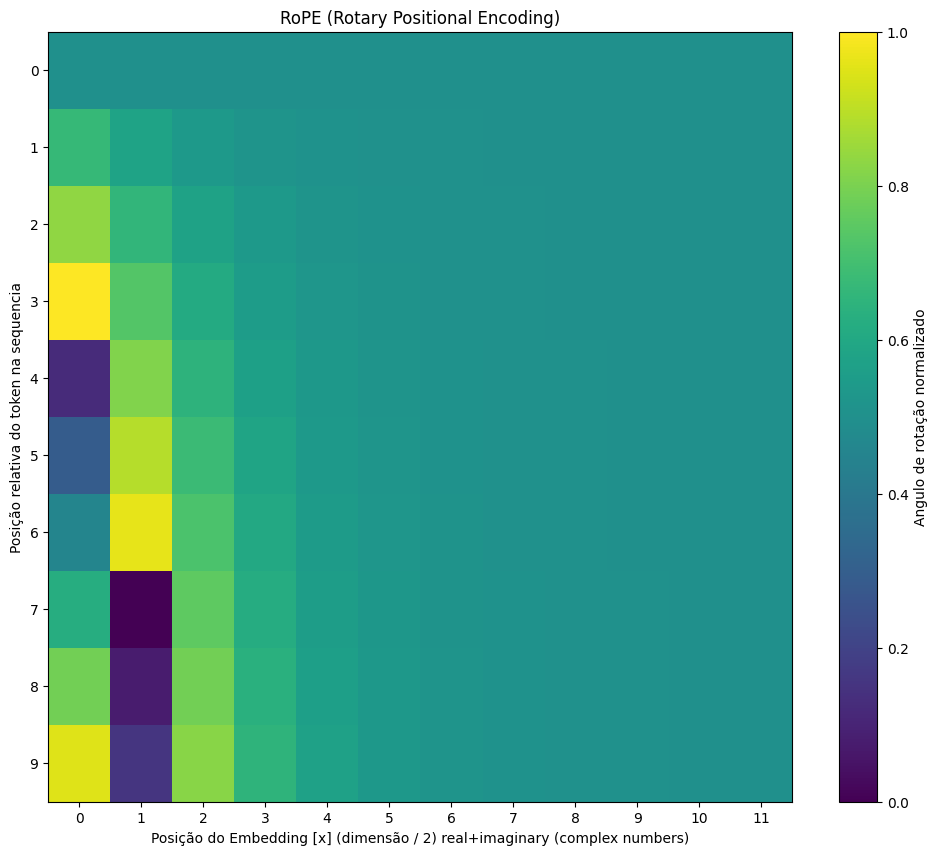

In [8]:
import matplotlib.pyplot as plt
import numpy as np

y , x = my_freqs.shape

# Matriz a ser rotacionada (conversao para numpy)
rotation_matrix = my_freqs.numpy()

# Calculo do angulo de rotacao com base nos numeros complexos
angles = np.angle(rotation_matrix)

print(my_freqs.shape)
print(angles.shape)

# Angulos normalizados entre 0 e 1: color mapping
normalized_angles = (angles - np.min(angles)) / (np.max(angles) - np.min(angles))

# Criação do color map
cmap = plt.cm.viridis

# Array de indices para os eixos x e y
col_indices = np.arange(x)
row_indices = np.arange(y)

# Plotting da matriz com variação de cores
plt.figure(figsize=(x, y))
plt.imshow(normalized_angles, cmap=cmap, aspect='auto')

# Setando os ticks
plt.xticks(col_indices, labels=col_indices)
plt.yticks(row_indices, labels=row_indices)

plt.title('RoPE (Rotary Positional Encoding)')
plt.colorbar(label='Angulo de rotação normalizado')
plt.xlabel('Posição do Embedding [x] (dimensão / 2) real+imaginary (complex numbers)')
plt.ylabel('Posição relativa do token na sequencia')
plt.show()


# RMS Normalization (Model LayerNorm)

Paper: https://arxiv.org/pdf/1910.07467.

Ganho de performance vs Layer norm tradicional

Exemplo: 
def layer_norm(embedding):
    n = len(embedding)
    mu = sum(embedding) / n  # Cálculo da média sem usar np.mean
    sigma_squared = sum((a_i - mu) ** 2 for a_i in a) / n  # Cálculo da variância
    sigma = np.sqrt(sigma_squared)  # Calculando o desvio padrão
    g = np.ones_like(embedding)  # Parâmetro de ganho
    embedding_normalized = (embedding - mu) / sigma * g  # Normalização
    return embedding_normalized

def rms_norm(embedding):
    rms = np.sqrt(np.mean(embedding**2))  # Cálculo do RMS
    g = np.ones_like(embedding)  # Parâmetro de ganho, inicializado como 1 para cada elemento
    a_normalized = embedding / rms * g  # Normalização
    return a_normalized



In [15]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


#x = torch.randn(1, 2, 6)
x = torch.tensor([[0.2,0.4,0.6,0.2,0.4,0.6],[1,2,1,2,1,2]])
rmsnorm = RMSNorm(6)

x_new = rmsnorm(x)

print(x)
print(x_new)



tensor([[0.2000, 0.4000, 0.6000, 0.2000, 0.4000, 0.6000],
        [1.0000, 2.0000, 1.0000, 2.0000, 1.0000, 2.0000]])
tensor([[0.4629, 0.9258, 1.3887, 0.4629, 0.9258, 1.3887],
        [0.6325, 1.2649, 0.6325, 1.2649, 0.6325, 1.2649]],
       grad_fn=<MulBackward0>)


# Funcionamento dos operadores binarios do torch

In [55]:
import torch
a = [True, False, True]

b = [not x for x in a]
print(b)

b = [~x for x in a]
print(b)

a = torch.tensor([True, False, True])

b = [~x for x in a]
print(b)

b = ~a
print(b)

print("-----")
a = torch.tensor([True, False, True])
b = torch.tensor([False, False, True])
c = torch.tensor([False, False, True])
d = torch.tensor([False, False, True])
print(f".... {a}")
print(f".... {b}")
print("-----")

b |= a
print(f"[|=] {b}")

c &= a
print(f"[&=] {c}")

d ^= a
print(f"[^=] {d}")





[False, True, False]
[-2, -1, -2]
[tensor(False), tensor(True), tensor(False)]
tensor([False,  True, False])
-----
.... tensor([ True, False,  True])
.... tensor([False, False,  True])
-----
[|=] tensor([ True, False,  True])
[&=] tensor([False, False,  True])
[^=] tensor([ True, False, False])
